# Visualizing word embeddings : Deep Learning for NLP embeddings.

This notebook will guide you through the implementation of Word2Vec, a popular model used in Natural Language Processing (NLP) to capture semantic meaning from text. We will apply this model to a dataset and visualize the learned word embeddings.

<center><img src="https://education-team-2020.s3.eu-west-1.amazonaws.com/ai-eng/w4-s3/deep_learning.png" width="1000"/></center>

## Tutorial

In this notebook, we will apply the Word2Vec model to a text dataset. The Word2Vec model learns to represent words in a continuous vector space, where semantically similar words are mapped to nearby points. We will walk through the following steps:

1. **Download the Training Data:** We'll start by downloading a large text corpus for training.
2. **Set up Word2Vec in TensorFlow:** We'll configure the Word2Vec model using TensorFlow, a popular machine learning library.
3. **Train the Model:** We'll train the Word2Vec model on the dataset to learn word embeddings.
4. **Visualize the Embeddings:** Finally, we'll visualize the learned word embeddings using dimensionality reduction techniques.

In [1]:
reset -fs

In [2]:
# I like to live dangerously ☠
import warnings
warnings.filterwarnings('ignore')

In [3]:
import collections
import math
import os
from pprint import pprint
import random
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.manifold import TSNE

%matplotlib inline  

### Step 1: Download the Dataset

To train our Word2Vec model, we need a large text corpus. In this step, we will download the "text8" dataset, a popular dataset used for training word embeddings. This dataset contains 100 MB of English Wikipedia text from 2006, which is commonly used in NLP tasks.

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(path, filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    
    if not os.path.exists(path+filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    
    statinfo = os.stat(path+filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    
    return filename

path = ""
filename = maybe_download(path, 'text8.zip', 31_344_016)

Found and verified text8.zip


> **Note:** While the dataset is being downloaded, feel free to look ahead at the upcoming code cells to get a sense of what we'll be doing next.

In [5]:
# Read the data into a list of strings.
def read_data(path, filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(path+filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(path, filename)
print('Dataset size: {:,} words'.format(len(vocabulary)))

Dataset size: 17,005,207 words


In [6]:
# Take a peak at the head
vocabulary[:20]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english']

### Observations on Preprocessing

- **Case and Punctuation:** Notice that none of the words in our dataset are capitalized, and there is no punctuation. This is likely due to preprocessing steps taken before we acquired the dataset, which ensures uniformity in the text.
- **Preprocessing Considerations:** Preprocessing is a crucial part of NLP tasks, and its specifics depend on the data and the intended use. For instance, while we're working with unigrams (single words), other tasks might benefit from encoding n-grams (combinations of words) to capture context better.

-----
Step 2: Build the dictionary 
-----

Now that we have our text data, the next step is to build a dictionary. This dictionary will map each unique word in our dataset to a unique integer code. 

Additionally, we'll keep track of the frequency of each word, which will help us prioritize the most common words.

In [7]:
vocabulary_size = 50_000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [8]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)

### Understanding the Key Variables

- **`data`:** A list of integer codes representing the words in the original text. Each word is replaced by its corresponding code from the `dictionary`.
- **`count`:** A list of tuples where each tuple contains a word and its frequency count in the dataset.
- **`dictionary`:** A dictionary mapping each word to its unique integer code.
- **`reverse_dictionary`:** A reverse mapping that converts integer codes back to their corresponding words.

In [9]:
del vocabulary # Reduce memory by getting rid of the "heavy" list of strings

In [10]:
data[:5] # An index of each word (as it appears in order) to its rank. Therefore we don't have reference the string

[5234, 3081, 12, 6, 195]

In [11]:
dictionary['the'] # word: rank

1

In [12]:
reverse_dictionary[5234] # rank: word

'anarchism'

In [13]:
print('Most common words:') 
print(*count[:5], sep="\n")

Most common words:
['UNK', 418391]
('the', 1061396)
('of', 593677)
('and', 416629)
('one', 411764)


In [14]:
print('Least common words:')
print(*count[-5:], sep="\n")

Least common words:
('codeword', 9)
('senussi', 9)
('unscr', 9)
('leonards', 9)
('hif', 9)


### Step 3: Generate a Training Batch for the Skip-Gram Model

In this step, we'll create a function to generate training batches for our skip-gram model. The skip-gram model is a variant of Word2Vec that predicts the context words given a target word. This function will help us prepare the data in the correct format for training the model.

In [15]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [16]:
batch, labels = generate_batch(batch_size=8, 
                               num_skips=2, 
                               skip_window=1)

In [17]:
# Example of self-supervised learning
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


----
Step 4: Build and train a skip-gram model.
-----

The Skip-Gram model is a type of neural network model used in Natural Language Processing (NLP) to learn distributed representations of words, commonly known as word embeddings. 

Word embeddings are dense vector representations of words that capture semantic relationships between them, meaning that words with similar meanings are mapped to similar points in the vector space.

### How the Skip-Gram Model Works
The goal of the Skip-Gram model is to predict the context words given a target word. Here's how it works:

Input: The model takes a single word (the target word) from the text as input.

Output: The model is trained to predict words that are likely to appear in the context of the target word within a specified window of words before and after the target word. This context window is typically referred to as the "skip window."

For example, if the sentence is "The cat sat on the mat," and the target word is "sat," the model might be asked to predict the words "The," "cat," "on," and "the," which appear around "sat."

In [18]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [19]:
import tensorflow.compat.v1 as v1

In [20]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = v1.placeholder(tf.int32, shape=[batch_size])
    train_labels = v1.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = v1.constant(valid_examples, dtype=tf.int32)

    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            v1.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            v1.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
        # Explanation of the meaning of NCE loss:
        #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
        loss = tf.reduce_mean(
          tf.nn.nce_loss(weights=nce_weights,
                         biases=nce_biases,
                         labels=train_labels,
                         inputs=embed,
                         num_sampled=num_sampled,
                         num_classes=vocabulary_size))

        # Construct the SGD optimizer using a learning rate of 1.0.
        optimizer = v1.train.GradientDescentOptimizer(1.0).minimize(loss)

        # Compute the cosine similarity between minibatch examples and all embeddings.
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_dataset)
        similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)

        # Add variable initializer.
        init = v1.global_variables_initializer()

----
Step 5: Begin training.
-----

In [25]:
num_steps = 2_001 #1 #2_001 #100_001

with v1.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2_000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 2_000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 4 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to '%s':" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
            print()
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  293.1549072265625
Nearest to 'th': originated, depress, inconceivable, unshielded,
Nearest to 'seven': ashamed, blockade, ladakh, biomedical,
Nearest to 'all': aelia, prester, burzum, osz,
Nearest to 'into': james, huac, plasmid, quadrivium,
Nearest to 'over': gwp, aston, pressured, foods,
Nearest to 'there': typical, unwieldy, dannebrog, subtracted,
Nearest to 'was': score, alexandrina, patagonian, galtieri,
Nearest to 'system': dyess, snl, overviews, plasmids,
Nearest to 'known': eugenia, conjure, trotsky, beavis,
Nearest to 'or': internationals, peruvian, joni, leaped,
Nearest to 'more': dehydration, indium, tippit, keen,
Nearest to 'would': thurston, conquers, dispersal, zamenhof,
Nearest to 'in': scraps, quixtar, evaluations, folksong,
Nearest to 'time': basel, mutations, eradication, quatre,
Nearest to 'called': danforth, sparks, goddard, altitudes,
Nearest to 'had': cryoprotectant, indicated, inventions, botanists,

Average loss at step  20

<center><img src="../images/watiing.jpg" width="700"/></center>

-----
Step 6: Visualize the embeddings with t-SNE.
----


In this step, we use the t-SNE algorithm to reduce the dimensionality of the learned word embeddings for visualization. 

The top 500 words (based on frequency) are plotted in a 2D space, allowing us to visually inspect the relationships and groupings among words. 

This visualization is a powerful tool to understand how well the model has learned semantic relationships.

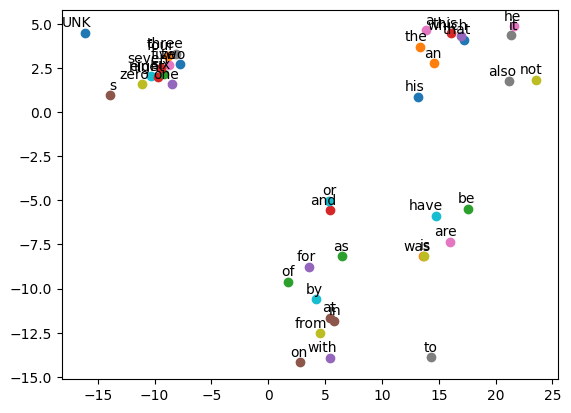

In [22]:
tsne = TSNE(perplexity=30, 
            n_components=2, 
            init='pca', 
            n_iter=5_000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

n_words_to_visualize = 40

for i, label in enumerate(labels[:n_words_to_visualize]):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

------

# Let's render and plot more samples.

In [23]:
def plot_with_labels(low_dim_embs, labels, filename='../images/tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

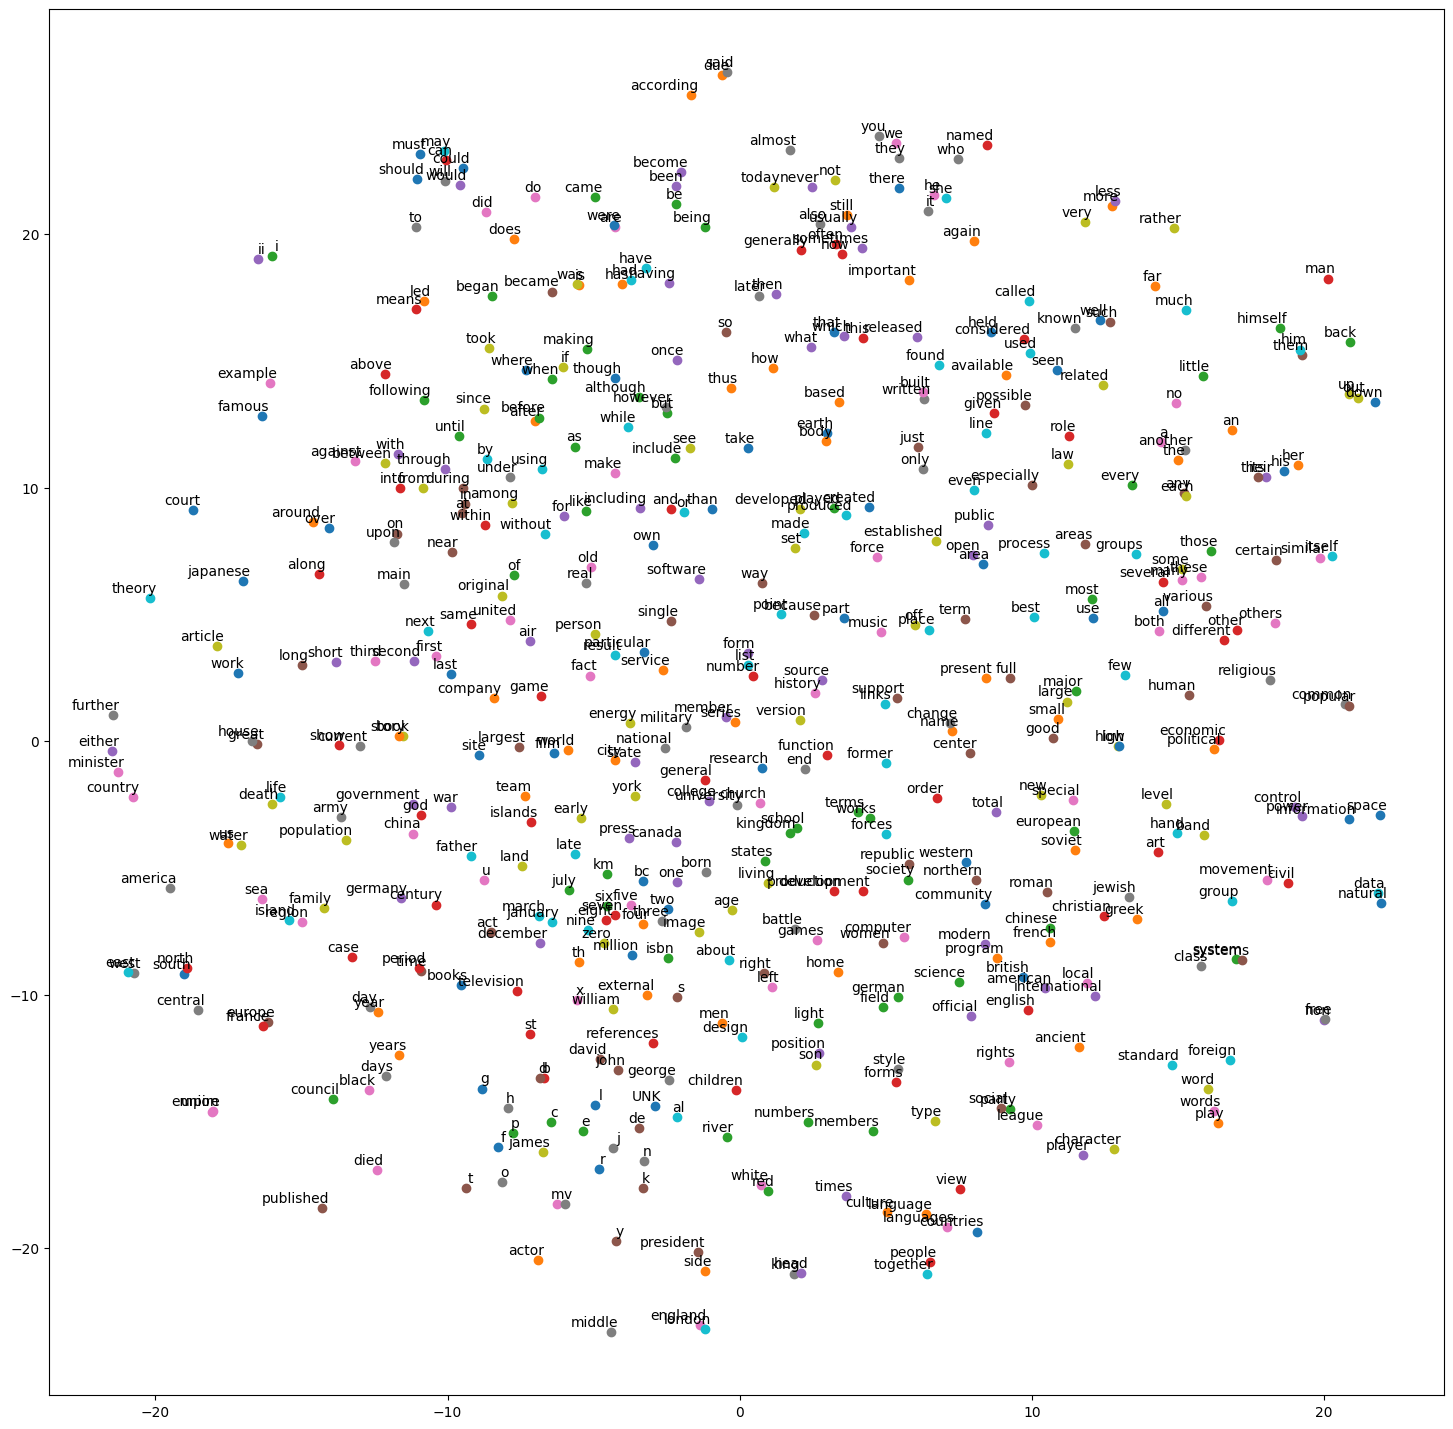

In [24]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# And voila!

Now you have a visual understanding of embeddings.

Thank you for following this tutorial!